# from allcools page: https://lhqing.github.io/ALLCools/cell_level/step_by_step/100kb/06-Clustering.html
Consensus Clustering
Purpose¶
The purpose of this step is to run consensus clustering.

Input
Cell-by-components matrix from the decompusition analysis.

Output
Adata file with cluster annotated.

In [1]:
import anndata
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scanpy as sc

from ALLCools.clustering import ConsensusClustering, Dendrogram, get_pc_centers
from ALLCools.plot import *

KeyboardInterrupt: 

In [ ]:
# clustering name
clustering_name = 'Group'

# input data
cell_meta_path = '../CellMetadata.PassQC_oocyte.csv'
adata_path = './adata.with_coords.h5ad'
coord_base = 'umap'

# ConsensusClustering
# Important factores
n_neighbors = 50
leiden_resolution = 1
# this parameter is the final target that limit the total number of clusters
# Higher accuracy means more conservative clustering results and less number of clusters
target_accuracy = 0.5
min_cluster_size = 5

# Other ConsensusClustering parameters
metric = 'euclidean'
consensus_rate = 0.5
leiden_repeats = 500
random_state = 0
train_frac = 0.5
train_max_n = 500
max_iter = 50
n_jobs = 40

# Dendrogram via Multiscale Bootstrap Resampling
nboot = 10000
method_dist = 'correlation'
method_hclust = 'average'

plot_type = 'static'

In [ ]:
cell_meta = pd.read_csv(cell_meta_path, index_col=0)
cell_meta

In [ ]:
adata = anndata.read_h5ad(adata_path)
adata = adata[adata.obs['L1'] == 'c1']
adata


In [21]:
#CONSENSUSE CLUSTERING:

cc = ConsensusClustering(model=None,
                         n_neighbors=n_neighbors,
                         metric=metric,
                         min_cluster_size=min_cluster_size,
                         leiden_repeats=leiden_repeats,
                         leiden_resolution=leiden_resolution,
                         consensus_rate=consensus_rate,
                         random_state=random_state,
                         train_frac=train_frac,
                         train_max_n=train_max_n,
                         max_iter=max_iter,
                         n_jobs=n_jobs,
                         target_accuracy=target_accuracy)

In [ ]:
if 'X_pca' not in adata.obsm:
    raise KeyError(
        'X_pca do not exist in the adata file, run PCA first before clustering.'
    )

In [24]:
print(adata.obsm['X_pca'].shape)


(33, 8)


In [23]:
cc.fit_predict(adata.obsm['X_pca'])

Computing nearest neighbor graph
Computing multiple clustering with different random seeds
Repeating leiden clustering 500 times
_leiden_runner generated an exception: 12 columns passed, passed data had 33 columns


ValueError: 12 columns passed, passed data had 33 columns

In [31]:
sc.tl.um(adata, color='group')



TypeError: pca() got an unexpected keyword argument 'color'

In [14]:
cc.plot_merge_process(plot_size=3)

No merge step to plot


In [35]:

# Plot merge process and save

plt.savefig(f"05j_cc_mergeprocess_plot_{var_dim}_bygroup.png")


No merge step to plot


<Figure size 640x480 with 0 Axes>

In [6]:

# Plot ConsensusClustering Details - Individual Leiden runs with diffreent random states 
adata.obs[f'{coord_base}_0'] = adata.obsm[f'X_{coord_base}'][:, 0]
adata.obs[f'{coord_base}_1'] = adata.obsm[f'X_{coord_base}'][:, 1]


In [7]:
fig, axes = cc.plot_leiden_cases(coord_data=adata.obs, coord_base=coord_base)
fig.savefig(f"05j_leiden_cases_plot_{var_dim}_c0bygroup.png")


AttributeError: 'NoneType' object has no attribute 'shape'

In [41]:
#merging stpes

len(set(cc._multi_leiden_clusters)), len(set(cc.label))

TypeError: 'NoneType' object is not iterable

In [ ]:
cc.plot_steps(coord_data=adata.obs, coord_base=coord_base)

In [8]:


# Save the plot to a file
plt.savefig(f"05j_clustering_steps_plot_{var_dim}_c0bygroup.png", dpi=300)  # Save as PNG with high resolution


NameError: name 'var_dim' is not defined

In [ ]:


# Plot Final Clustering Results - Cluster Labels
adata.obs[clustering_name] = cc.label

# Save the clustering results
adata.obs[[clustering_name]].to_csv(f'{clustering_name}_clustering_labels.csv')

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = categorical_scatter(data=adata, ax=ax, coord_base=coord_base, hue=clustering_name, show_legend=True)
fig.savefig(f"05j_final_clustering_labels_{var_dim}_cobyGroup.png")


In [ ]:
# Plot Final Clustering Results - Final prediction Probablity
adata.obs[clustering_name + '_proba'] = cc.label_proba

fig, ax = plt.subplots(figsize=(4, 4), dpi=250)
_ = continuous_scatter(data=adata,
                       ax=ax,
                       hue_norm=(0, 1),
                       hue=clustering_name + '_proba',
                        text_anno=clustering_name,
                       coord_base=coord_base)
fig.savefig(f"05j_final_prediction_probablity_{var_dim}_c0bygroup.png")



ValueError: Could not interpret value `Group_proba` for `y`. An entry with this name does not appear in `data`.

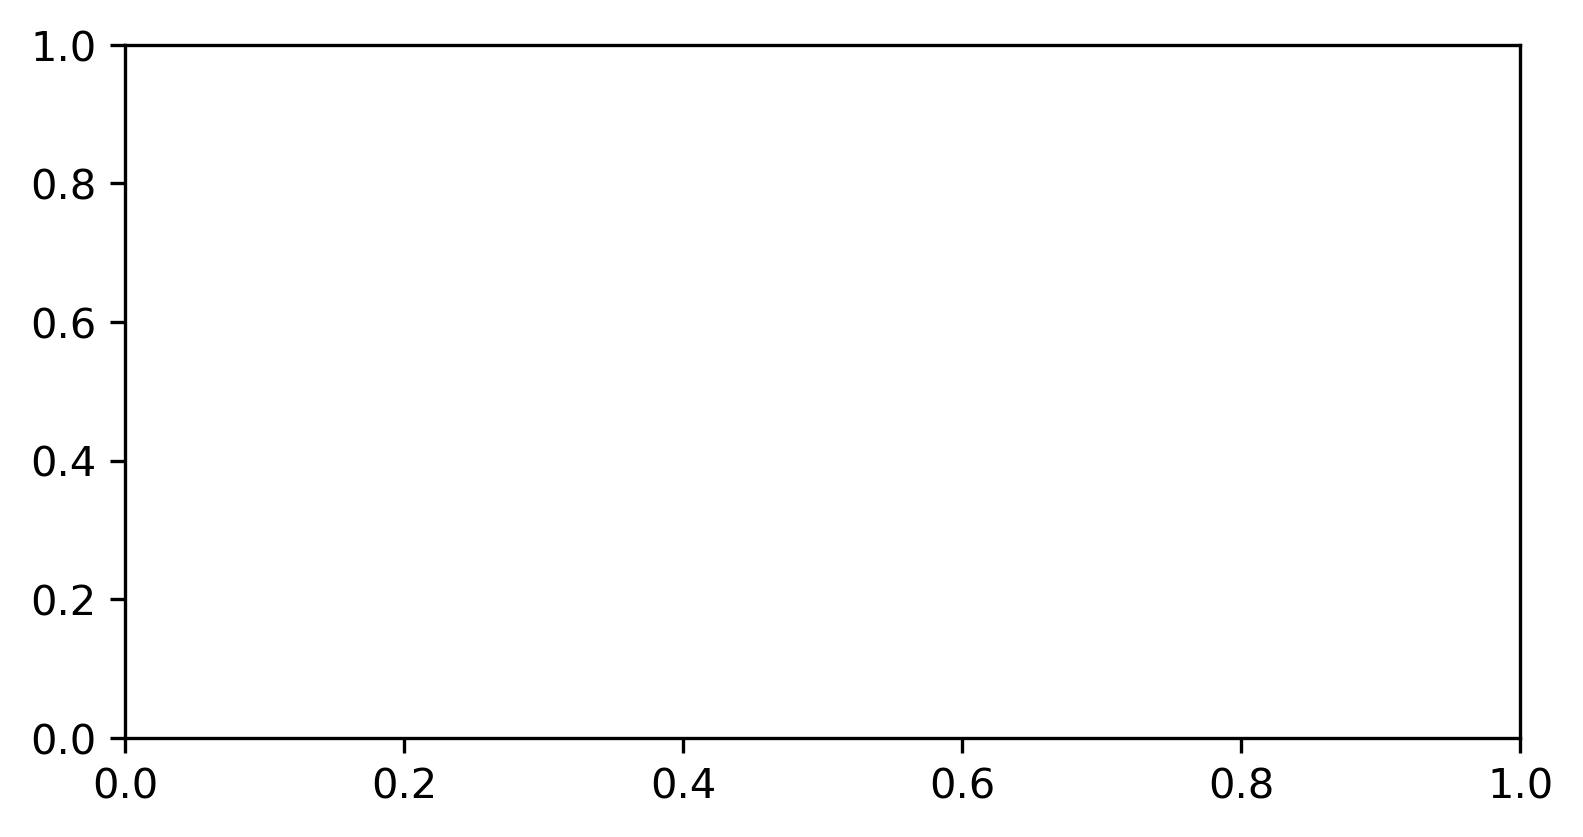

In [9]:
#Prediction probibility per cluster
fig, ax = plt.subplots(figsize=(6, 3), dpi=300)

sns.violinplot(data=adata.obs,
               x=clustering_name,
               y=clustering_name + '_proba',
               scale='width',
               linewidth=0.5,
               cut=0,
               ax=ax)
ax.set(ylim=(0, 1), title='Prediction Probability Per Cluster')
ax.xaxis.set_tick_params(rotation=90)
ax.grid(linewidth=0.5, color='gray', linestyle='--')
sns.despine(ax=ax)

fig.savefig(f"05j_final_prediction_probablity_percluster_{var_dim}_c0bygroup.png")



In [43]:
# using the cluster centroids in PC space to calculate dendrogram
pc_center = get_pc_centers(adata, group=clustering_name)

# calculate the cluster dendrogram using R package pvclust
dendro = Dendrogram(nboot=nboot,
                    method_dist=method_dist,
                    method_hclust=method_hclust,
                    n_jobs=n_jobs)
dendro.fit(pc_center)

KeyError: 'L1'

AttributeError: module 'ALLCools.plot.dendro' has no attribute 'dendrogram'

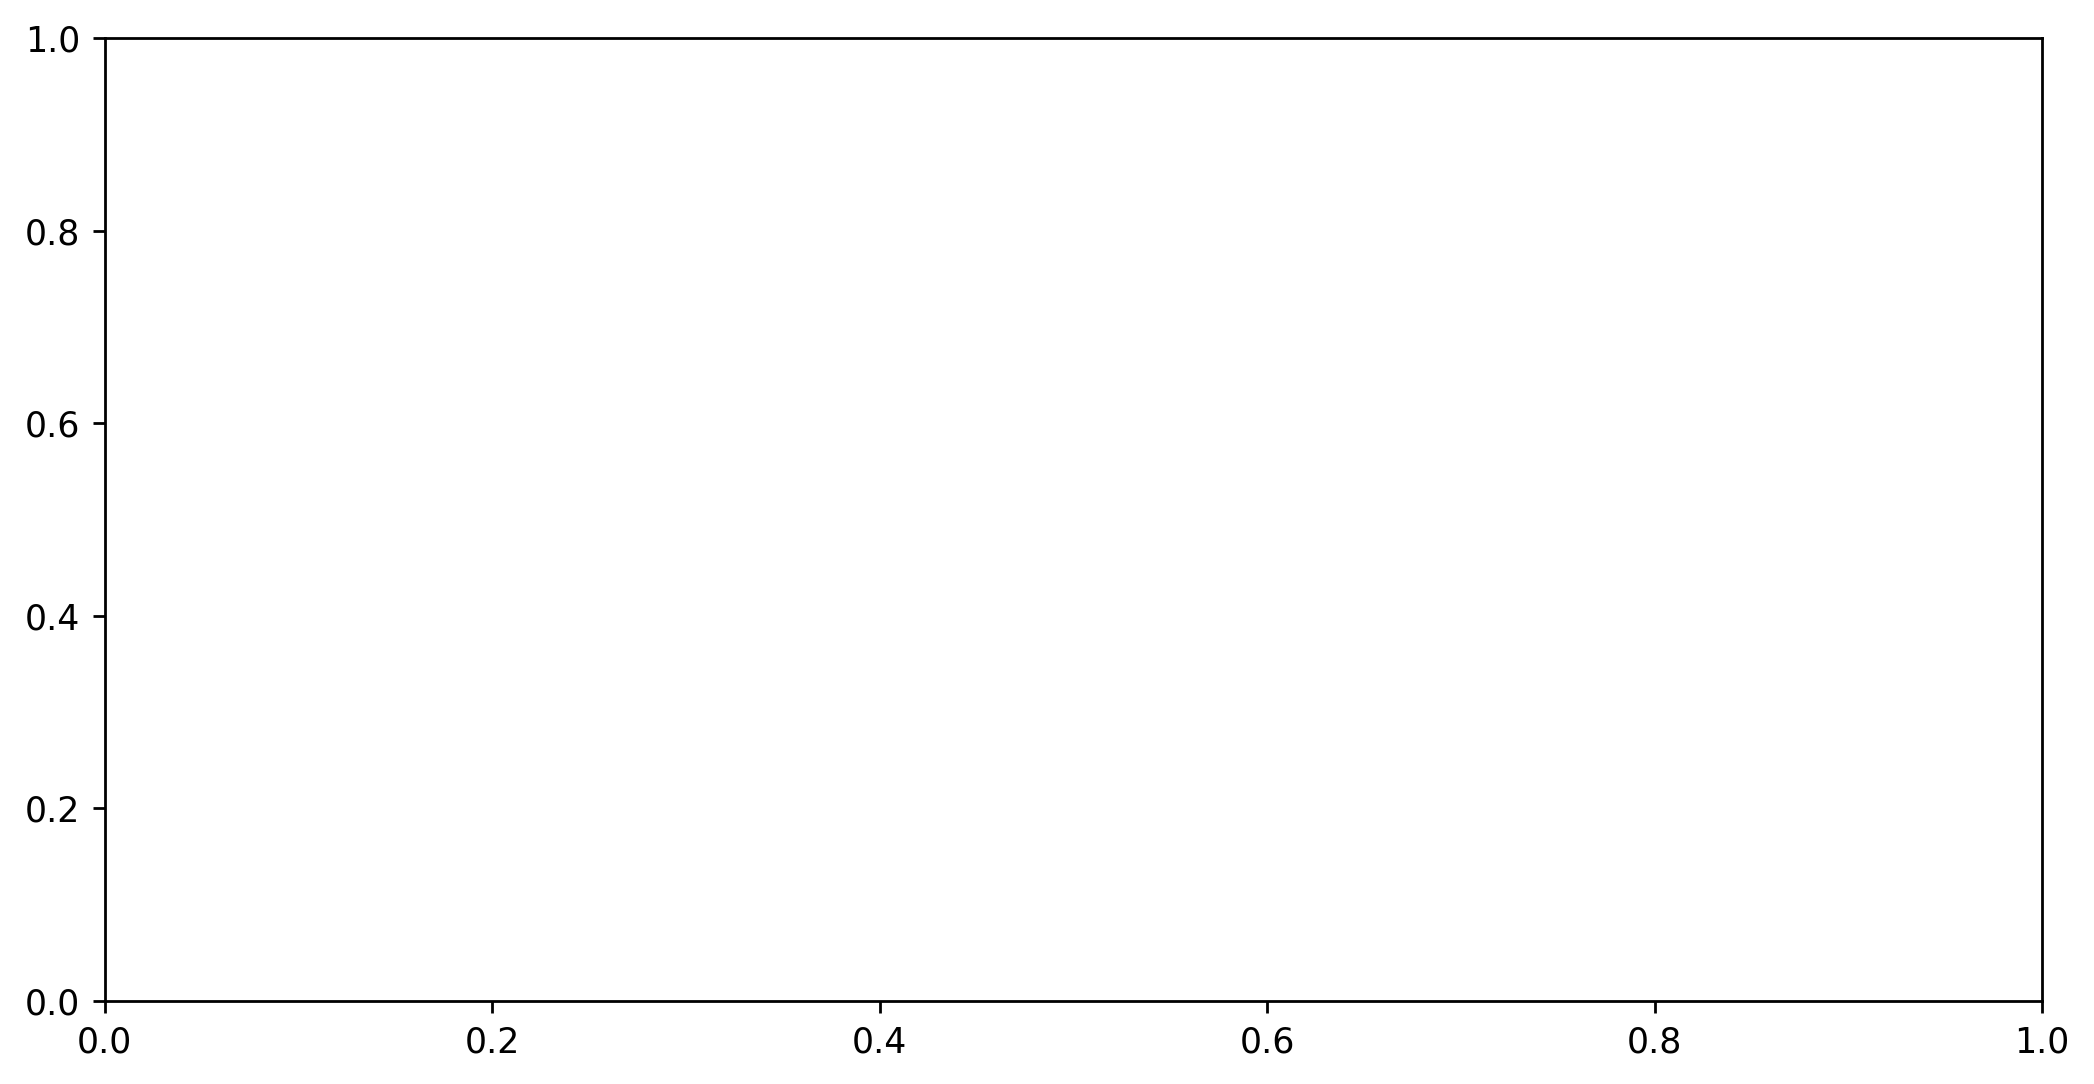

In [46]:
fig, ax = plt.subplots(figsize=(10, 5), dpi=250)
_ = plot_dendrogram(dendro=dendro.dendrogram,
                    linkage_df=dendro.linkage,
                    ax=ax,
                    plot_non_singleton=False,
                    line_hue=dendro.edge_stats['au'], # au is the branch confidence score, see pvclust documentation
                    line_hue_norm=(0.5, 1))


In [ ]:
fig.savefig(f"05j_cluster_dendrogram_{var_dim}.png")


In [ ]:
try:
    anno = pd.read_csv(
    '../../../data/Brain/snmC-seq2/HIP.Annotated.CellMetadata.csv.gz',
    index_col=0)
    adata.obs['CellTypeAnno'] = anno['MajorType']
    fig, axes = plt.subplots(figsize=(8, 4), dpi=250, ncols=2)
    ax = axes[0]
    _ = categorical_scatter(data=adata.obs,
                            ax=ax,
                            hue=clustering_name,
                            coord_base=coord_base,
                            palette='tab20',
                            text_anno=clustering_name,
                            show_legend=False)
    ax = axes[1]
    _ = categorical_scatter(data=adata.obs.dropna(subset=['CellTypeAnno']),
                            ax=ax,
                            hue='CellTypeAnno',
                            coord_base=coord_base,
                            palette='tab20',
                            text_anno='CellTypeAnno',
                            show_legend=False)
except BaseException:
    pass

In [61]:
adata

AnnData object with n_obs × n_vars = 120 × 1483
    obs: 'leiden', 'umap_0', 'umap_1', 'L1', 'L1_proba'
    var: 'chrom', 'end', 'start', 'CHN_mean', 'CHN_dispersion', 'CHN_cov', 'CHN_score', 'CHN_feature_select', 'CGN_mean', 'CGN_dispersion', 'CGN_cov', 'CGN_score', 'CGN_feature_select', 'leiden_enriched_features'
    uns: 'leiden', 'leiden_colors', 'leiden_feature_enrichment', 'leiden_sizes', 'log', 'neighbors', 'paga', 'umap'
    obsm: 'X_pca', 'X_tsne', 'X_umap'
    obsp: 'connectivities', 'distances'

                        Group  AnimalID Type  TotalRead
cell                                                   
4636344664PO1NC5L9C   Control     46363   PO    8100000
4598245001PO2NC4F8C   Control     45982   PO    5600000
4566944700PO2NC5P8C   Control     45669   PO   14900000
4520844650PO1NC5A7S  Stressed     45208   PO    2400000
4139144650PO3NC3E3C   Control     41391   PO   27100000


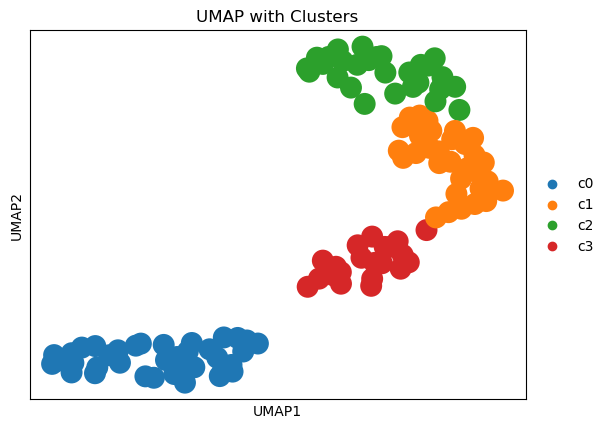

<Figure size 640x480 with 0 Axes>

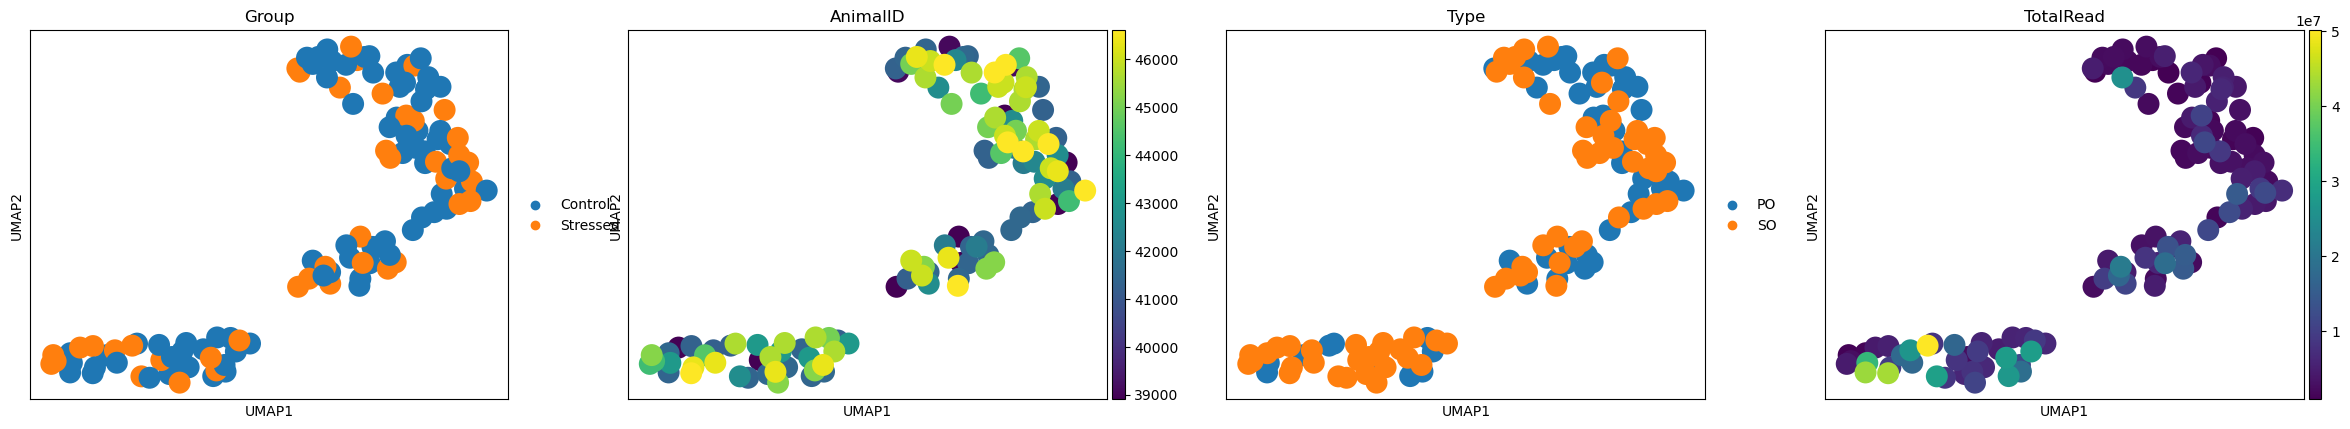

<Figure size 640x480 with 0 Axes>

In [67]:
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt

# Load metadata
metadata_path = 'CellMetadata.PassQC_oocyte.csv'
metadata = pd.read_csv(metadata_path, index_col=0)

# Add Group and AnimalID to adata.obs
adata.obs['Group'] = metadata['Group']
adata.obs['AnimalID'] = metadata['AnimalID']
adata.obs['Type'] = metadata['Type']
adata.obs['TotalRead'] = metadata['TotalRead']
adata.obs['mCGFrac'] = metadata['mCGFrac']

# Verify addition
print(adata.obs[['Group', 'AnimalID', 'Type', 'TotalRead']].head())

# Plot the UMAP with the original clustering labels (assuming 'leiden' or another clustering label is present)
sc.pl.umap(adata, color='L1', title='UMAP with Clusters')
plt.savefig('05j_umap_withlabeledclustert.png', dpi=300, bbox_inches='tight')

# Plot the UMAP with metadata labels
sc.pl.umap(adata, color=['Group', 'AnimalID', 'Type', 'TotalRead'])

# Save the plot with metadata labels
plt.savefig('05j_umap_withmetadatalabels_plot_c0bygroup.png', dpi=300, bbox_inches='tight')


In [54]:
cc.save(f'05j_.{clustering_name}.ConcensusClustering.model.lib')
dendro.save(f'05j_.{clustering_name}.Dendrogram.lib')
adata.write_h5ad(adata_path)


AttributeError: module 'ALLCools.plot.dendro' has no attribute 'save'